# Fetal Data AutoEncoder

- Given data in this link: https://drive.google.com/file/d/1zsbLlmbSzHkRDpqISi_g-CDENlVVzlbf/view?usp=sharing
- Please make a model for anomaly detection and use this model to identify the minority class
- Please calculate the performance evaluation : accuracy, precision, recall and F1 score

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [33]:
data = pd.read_csv("Data/fetal_data.csv")
data = data.drop(columns=["Unnamed: 0"])
data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,0.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,0.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,0.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,0.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,0.0


In [34]:
for col in data.columns:
    print(f"{col}: {data[col].nunique()}")

baseline value: 48
accelerations: 20
fetal_movement: 102
uterine_contractions: 16
light_decelerations: 16
severe_decelerations: 2
prolongued_decelerations: 6
abnormal_short_term_variability: 75
mean_value_of_short_term_variability: 57
percentage_of_time_with_abnormal_long_term_variability: 87
mean_value_of_long_term_variability: 249
histogram_width: 154
histogram_min: 109
histogram_max: 86
histogram_number_of_peaks: 18
histogram_number_of_zeroes: 9
histogram_mode: 88
histogram_mean: 103
histogram_median: 95
histogram_variance: 133
histogram_tendency: 3
fetal_health: 2


In [35]:
num_cols = ['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'light_decelerations', 
       'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability', 'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks', 'histogram_number_of_zeroes', 'histogram_mode', 
       'histogram_mean', 'histogram_median', 'histogram_variance', 'histogram_tendency']
cat_cols = ['severe_decelerations', 'fetal_health']

In [36]:
def num_plot(data):
    n = len(num_cols)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 3 * n))

    for i, col in enumerate(num_cols):
        sns.boxplot(x=data[col], ax=axes[i, 0])
        axes[i, 0].set_title(f'Boxplot of {col}')

        sns.histplot(data[col], kde=True, bins=30, ax=axes[i, 1])
        axes[i, 1].set_title(f'Histogram of {col}')

    fig.suptitle("Boxplot and Histogram of Numerical Columns", fontsize=20, y=1)
    plt.tight_layout()
    plt.show()

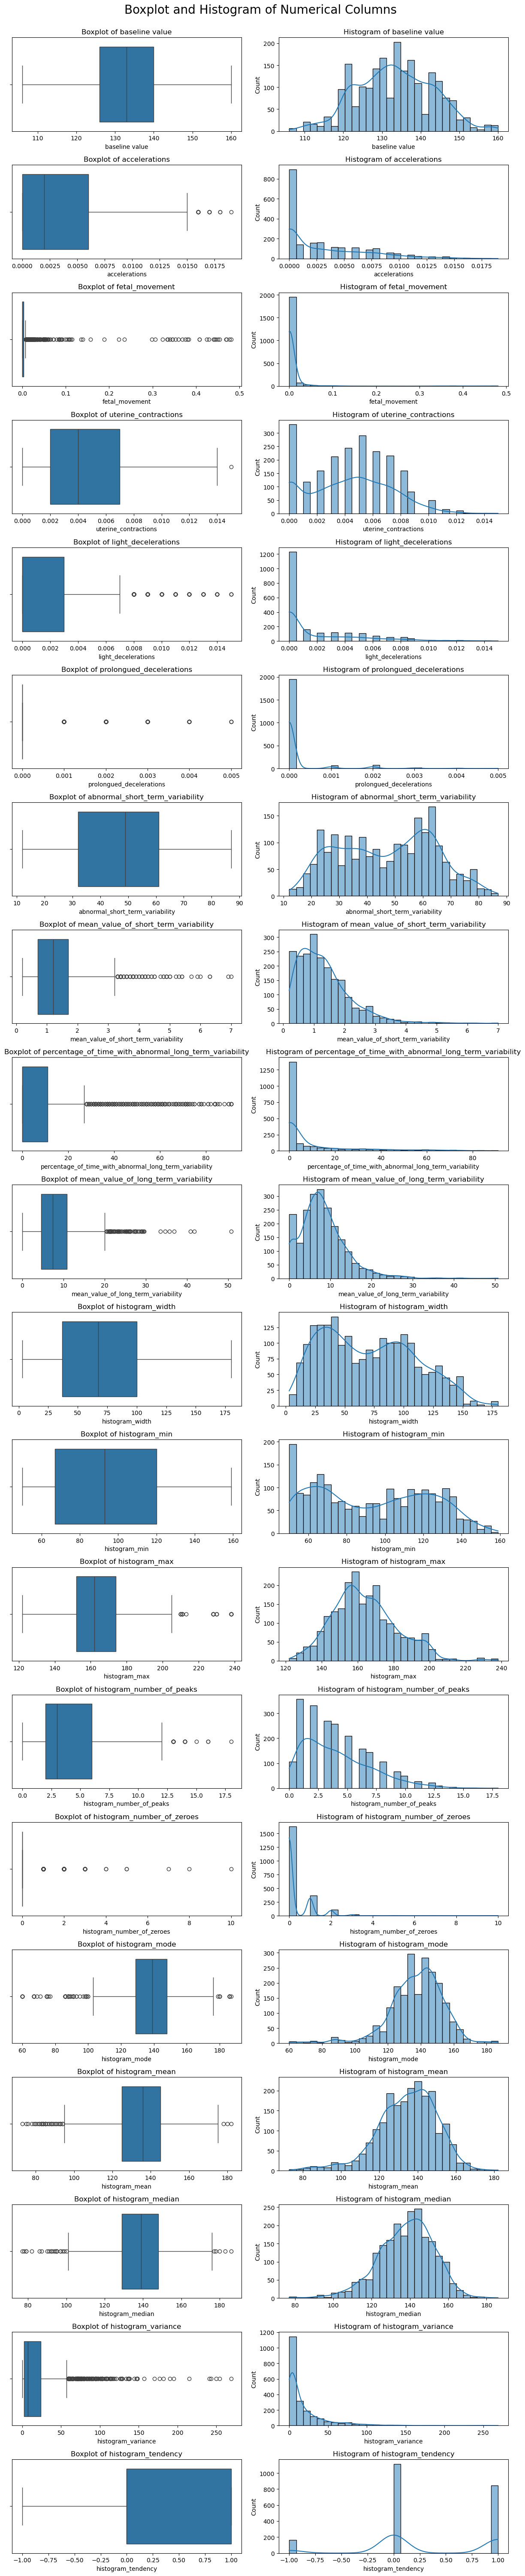

In [37]:
num_plot(data)

In [38]:
def cat_plot(data):
    n = len(cat_cols)
    fig, axes = plt.subplots(nrows=round(n/2), ncols=2, figsize=(12, 2 * n))

    axes = axes.flatten()
    for i, col in enumerate(cat_cols):
        order = data[col].value_counts().index
        sns.countplot(data=data, x=col, ax=axes[i], order=order)
        axes[i].set_title(f'Barplot of {col}')

    fig.suptitle("Barplot of Numerical Columns", fontsize=20, y=1)
    plt.tight_layout()
    plt.show()

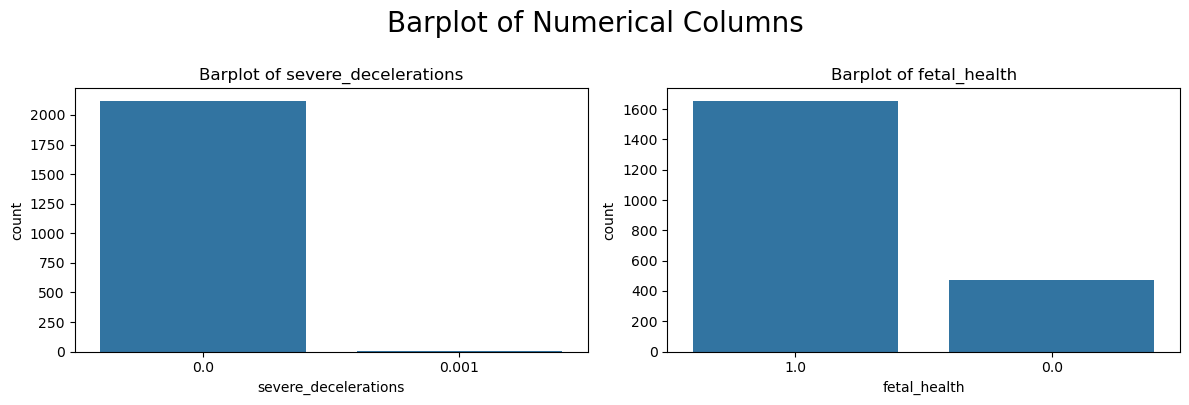

In [39]:
cat_plot(data)

In [40]:
X = data.drop(columns=["fetal_health"])
y = data["fetal_health"]

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
timesteps = 21
n_features = 1
latent_dim = 16

In [43]:
n_samples = (len(X_scaled) // timesteps) * timesteps
X_trimmed = X_scaled[:n_samples]
y_trimmed = y.values[:n_samples]

In [44]:
X_seq = X_trimmed.reshape(-1, timesteps, n_features)
y_seq = y_trimmed.reshape(-1, timesteps)[:, -1]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
inputs = Input(shape=(timesteps, n_features))
flat = Flatten()(inputs)
encoded = Dense(64, activation='relu')(flat)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(timesteps * n_features, activation='sigmoid')(decoded)  
decoded = Reshape((timesteps, n_features))(decoded)  

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 21, 1)]           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 21)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                1408      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_15 (Dense)             (None, 21)                1365      
_________________________________________________________________
reshape_3 (Reshape)          (None, 21, 1)            

In [50]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/50
54/54 [==============================] - 0s 2ms/step - loss: 5756.9990 - val_loss: 5714.4043
Epoch 2/50
54/54 [==============================] - 0s 550us/step - loss: 5744.8340 - val_loss: 5714.3931
Epoch 3/50
54/54 [==============================] - 0s 550us/step - loss: 5744.7896 - val_loss: 5714.3550
Epoch 4/50
54/54 [==============================] - 0s 556us/step - loss: 5744.7891 - val_loss: 5714.3550
Epoch 5/50
54/54 [==============================] - 0s 539us/step - loss: 5744.7881 - val_loss: 5714.3550
Epoch 6/50
54/54 [==============================] - 0s 511us/step - loss: 5744.7871 - val_loss: 5714.3550
Epoch 7/50
54/54 [==============================] - 0s 597us/step - loss: 5744.7871 - val_loss: 5714.3550
Epoch 8/50
54/54 [==============================] - 0s 1ms/step - loss: 5744.7866 - val_loss: 5714.3550
Epoch 9/50
54/54 [==============================] - 0s 557us/step - loss: 5744.7876 - val_loss: 5714.3550
Epoch 10/50
54/54 [==============================]

In [53]:
encoder = Model(inputs, encoded)

In [54]:
autoencoder.save('autoencoder_model.h5')
encoder.save('encoder_model.h5')

In [55]:
encoded_features = encoder.predict(X_test)
print("Encoded features shape:", encoded_features.shape)

Encoded features shape: (426, 32)
